In [1]:
from ArielUtils.Constants import *
import numpy as np
from numpy import exp, pi

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def fitness_function(distance, transit_duration, orbital_period, quality_metric, time_till_event=0, slewrate=SLEWRATE, settle_time = SETTLE_TIME, baseline_duration=BASELINE_DURATION):
    wait_time = time_till_event - (distance/slewrate + settle_time + baseline_duration/2)
    if wait_time < 0:
        F = 0
    else:
        F = orbital_period * quality_metric /(wait_time+1)
    return F, wait_time


N = 1000

distances = np.random.random(N)*pi/4
transit_durations = np.random.random(N)*300
orbital_periods = np.random.random(N)*10000
quality_metrics= np.random.random(N)*100
event_timing = np.random.random(N)*50 + 100
radii = np.random.random(N)*10**(np.random.randint(59, 80)/10)

fitnesses = []
wait_times = []
for i in range(N):
    fit = fitness_function(distances[i],
                            transit_durations[i],
                            orbital_periods[i],
                            quality_metrics[i],
                            time_till_event=event_timing[i]
                            )
    fitnesses.append(fit[0])
    wait_times.append(fit[1])


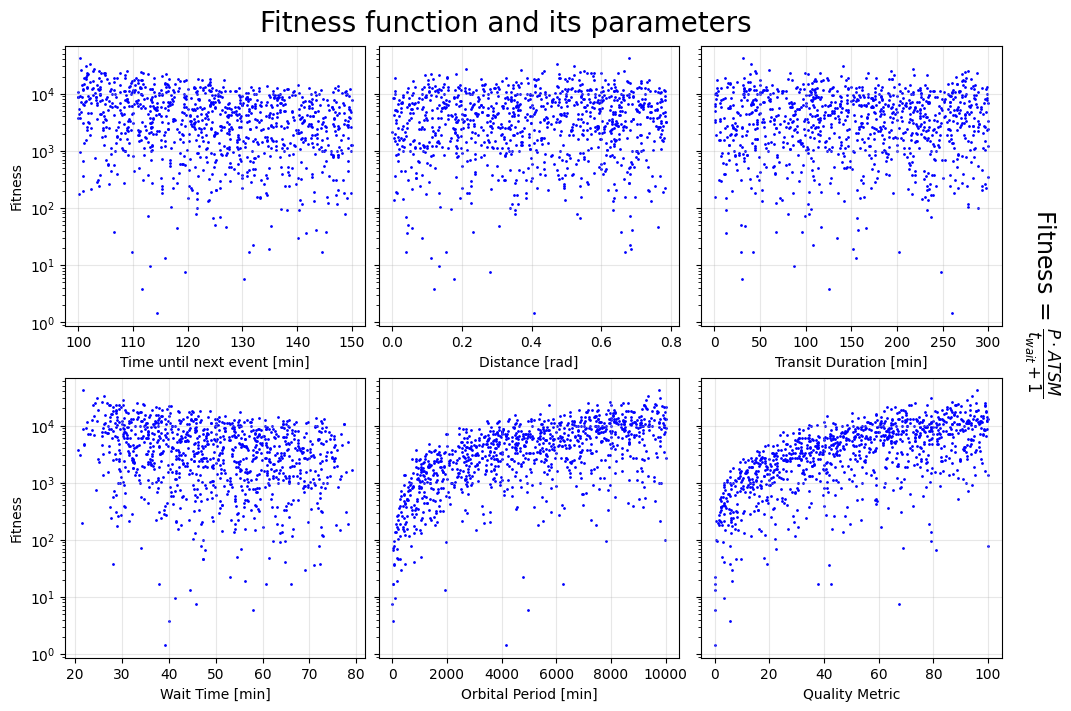

In [3]:
fig, axs = plt.subplots(2,3, sharey=True, layout='constrained', figsize=(10,7))

grid = True
alpha_grid = .3
size = 1
scale = 'log'
color = 'blue'

axs[0,0].scatter(event_timing, fitnesses, s=size, color=color)
axs[0,0].set_yscale(scale)
axs[0,0].set_ylabel('Fitness')
axs[0,0].set_xlabel('Time until next event [min]')
axs[0,0].grid(grid, alpha=alpha_grid)

axs[0,1].scatter(distances, fitnesses, s=size, color=color)
axs[0,1].set_yscale(scale)
axs[0,1].set_xlabel('Distance [rad]')
axs[0,1].grid(grid, alpha=alpha_grid)

axs[0,2].scatter(transit_durations, fitnesses, s=size, color=color)
axs[0,2].set_yscale(scale)
axs[0,2].set_xlabel('Transit Duration [min]')
axs[0,2].grid(grid, alpha=alpha_grid)

axs[1,0].scatter(wait_times, fitnesses, s=size, color=color)
axs[1,0].set_yscale(scale)
axs[1,0].set_ylabel('Fitness')
axs[1,0].set_xlabel('Wait Time [min]')
axs[1,0].grid(grid, alpha=alpha_grid)

axs[1,1].scatter(orbital_periods, fitnesses, s=size, color=color)
axs[1,1].set_yscale(scale)
axs[1,1].set_xlabel('Orbital Period [min]')
axs[1,1].grid(grid, alpha=alpha_grid)

axs[1,2].scatter(quality_metrics, fitnesses, s=size, color=color)
axs[1,2].set_yscale(scale)
axs[1,2].set_xlabel('Quality Metric')
axs[1,2].grid(grid, alpha=alpha_grid)

fig.text(1.03,.71, 
         r'Fitness = $\frac{P \cdot ATSM }{t_{wait}+1}$ ', 
         fontsize=17, rotation=-90, rotation_mode='anchor')

fig.suptitle('Fitness function and its parameters', fontsize=20)

fig.savefig('Fitness/Fitness function and its parameters', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Ben\AppData\Local\Temp\ipykernel_53000\3994114330.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=6)


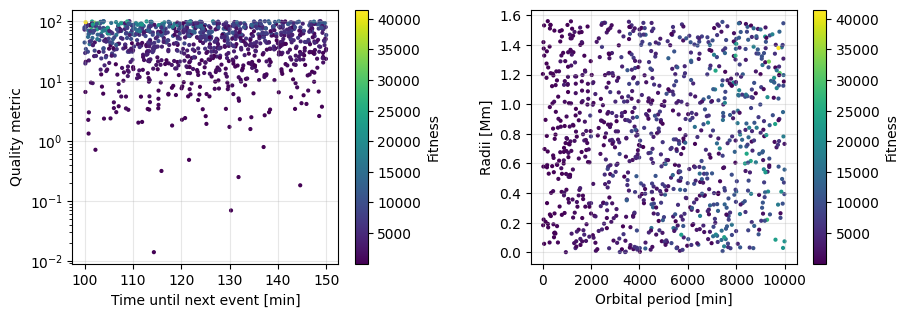

In [4]:
fig, axs = plt.subplots(1,2, sharey=False, layout='constrained', figsize=(10,4.5))
plt.tight_layout(pad=6)

grid = True
alpha_grid = .3
size = 4
scale = 'log'
color = 'blue'

im1 = axs[0].scatter(event_timing, quality_metrics, c=fitnesses, s=size, cmap='viridis')
axs[0].set_yscale(scale)
axs[0].set_ylabel('Quality metric')
axs[0].set_xlabel('Time until next event [min]')
axs[0].grid(grid, alpha=alpha_grid)
plt.colorbar(im1, label="Fitness")

im2 = axs[1].scatter(orbital_periods, radii/6.4e6, c=fitnesses, s=size, cmap='viridis')
# axs[1].set_yscale(scale)
axs[1].set_ylabel('Radii [Mm]')
axs[1].set_xlabel('Orbital period [min]')
axs[1].grid(grid, alpha=alpha_grid)
plt.colorbar(im2, label="Fitness")

plt.show()

### Trying it out on real data:

In [5]:
from ArielUtils.Functions import fitness, dist_angle
from ArielUtils.Constants import T0
import pandas as pd
import matplotlib.colors as colors

In [6]:
df = pd.read_csv("ASM_Ariel_sort.csv")
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Star Name', 'Planet Name',
       'Tier 1 Transits', 'Tier 2 Transits', 'Tier 3 Transits',
       'Tier 1 Eclipses', 'Tier 2 Eclipses', 'Tier 3 Eclipses',
       ...
       'Transit Depth [%]', 'Transit Depth Error Upper [%]',
       'Transit Depth Error Lower [%]', 'Known (Y=1,N=0)', 'Discovery Year',
       'Telescope', 'ESM', 'pl_g', 'ASM', 'cumulative days'],
      dtype='object', length=103)

In [45]:
current_pos = (0,0) # ra, dec

targets = df[['Star RA', 'Star Dec', 'Planet Radius [Re]', 'Planet Mass [Me]', 'Planet Period [days]', 'Transit Duration [s]', 'ASM']]
length = len(targets['Star RA'])
targets = targets.assign(Distance=dist_angle(current_pos[1], current_pos[0], np.radians(targets['Star Dec']), np.radians(targets['Star RA'])))
# targets = targets.assign(TTNT=np.random.random(length)*50)
# targets = targets.assign(Quality=np.random.random(length)*100)
targets = targets.assign(T_ref=T0)
time = Time(59945, format='mjd')# MJD calendar (1201, Oct 12)

for index, target in targets.iterrows():
        period = target['Planet Period [days]']
        diff = time - target['T_ref']
        time_till_transit = (period - (diff.value)) % period
        fit_val, wait_time = fitness(target['Distance'], 
                                    target['Transit Duration [s]']/60,
                                    period*24*60, 
                                    time_till_transit*24*60,
                                    target['ASM'],
                                    
                                    )
        targets.at[index, 'Fitness'] = fit_val
        targets.at[index, 'Wait Time'] = wait_time
        targets.at[index, 'TTNT'] = time_till_transit*24*60

targets.head(3)

,Star RA,Star Dec,Planet Radius [Re],Planet Mass [Me],Planet Period [days],Transit Duration [s],ASM,Distance,T_ref,Fitness,Wait Time,TTNT
0,0.185606,-54.830823,22.754231,1021.182670,0.980973,6086.249957,96.359355,0.956982,-240000.0,266.662747,509.447707,531.757381
1,300.182122,22.709776,12.666148,370.587922,2.218576,6544.787710,61.445837,1.088547,-240000.0,68.952600,2845.941553,2869.926364
2,36.712738,37.550444,17.855906,665.214855,1.219870,9739.030430,29.993609,0.882068,-240000.0,130.371840,403.129898,424.485733


C:\Users\Ben\AppData\Local\Temp\ipykernel_53000\786984523.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=6)


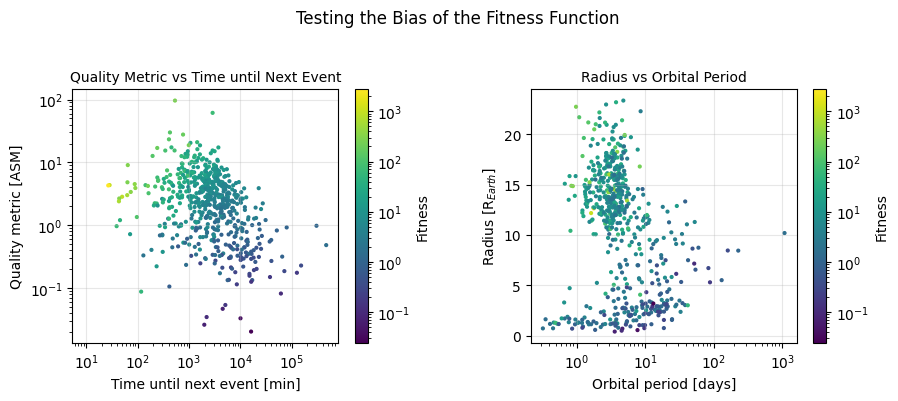

In [46]:
fig, axs = plt.subplots(1,2, sharey=False, layout='constrained', figsize=(10,4.5))
plt.tight_layout(pad=6)

fig.suptitle("Testing the Bias of the Fitness Function")

grid = True
alpha_grid = .3
size = 4
scale = 'log'
color = 'blue'
cmap = 'viridis'

im1 = axs[0].scatter(targets['TTNT'], targets['ASM'], c=targets['Fitness'], s=size, cmap=cmap, norm='log')
axs[0].set_yscale(scale)
axs[0].set_xscale(scale)
axs[0].set_ylabel('Quality metric [ASM]')
axs[0].set_xlabel('Time until next event [min]')
axs[0].grid(grid, alpha=alpha_grid)
axs[0].set_title('Quality Metric vs Time until Next Event', fontsize=10)
plt.colorbar(im1, label="Fitness")

im2 = axs[1].scatter(targets['Planet Period [days]'], targets['Planet Radius [Re]'], c=targets['Fitness'], s=size, cmap=cmap, norm='log')
# axs[1].set_yscale(scale)
axs[1].set_xscale(scale)
axs[1].set_ylabel(r'Radius [R$_{Earth}$]')
axs[1].set_xlabel('Orbital period [days]')
axs[1].grid(grid, alpha=alpha_grid)
axs[1].set_title('Radius vs Orbital Period', fontsize=10)
plt.colorbar(im2, label="Fitness")

plt.savefig("Fitness/Quality vs TTNT and Radius vs Period.png", bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Ben\AppData\Local\Temp\ipykernel_53000\1932836487.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=6)


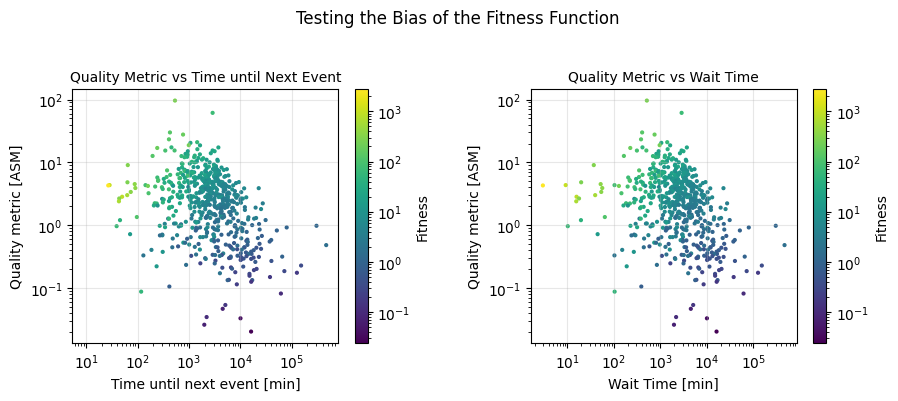

In [9]:
fig, axs = plt.subplots(1,2, sharey=False, layout='constrained', figsize=(10,4.5))
plt.tight_layout(pad=6)

fig.suptitle("Testing the Bias of the Fitness Function")

grid = True
alpha_grid = .3
size = 4
scale = 'log'
color = 'blue'
cmap = 'viridis'

im1 = axs[0].scatter(targets['TTNT'], targets['ASM'], c=targets['Fitness'], s=size, cmap=cmap, norm='log')
axs[0].set_yscale(scale)
axs[0].set_xscale(scale)
axs[0].set_ylabel('Quality metric [ASM]')
axs[0].set_xlabel('Time until next event [min]')
axs[0].grid(grid, alpha=alpha_grid)
axs[0].set_title('Quality Metric vs Time until Next Event', fontsize=10)
plt.colorbar(im1, label="Fitness")

im2 = axs[1].scatter(targets['Wait Time'], targets['ASM'], c=targets['Fitness'], s=size, cmap=cmap, norm='log')
axs[1].set_yscale(scale)
axs[1].set_xscale(scale)
axs[1].set_ylabel('Quality metric [ASM]')
axs[1].set_xlabel('Wait Time [min]')
axs[1].grid(grid, alpha=alpha_grid)
axs[1].set_title('Quality Metric vs Wait Time', fontsize=10)
plt.colorbar(im2, label="Fitness")

plt.savefig("Fitness/Quality vs TTNT and Quality vs Wait.png", bbox_inches='tight', dpi=300)
plt.show()

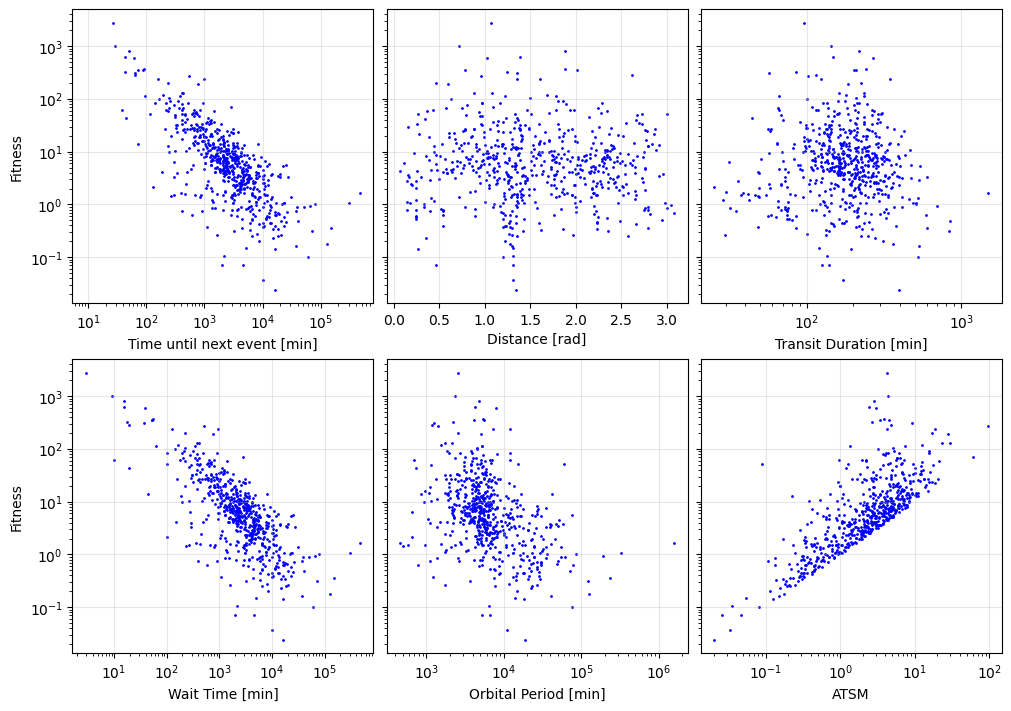

In [42]:
fig, axs = plt.subplots(2,3, sharey=True, layout='constrained', figsize=(10,7))

grid = True
alpha_grid = .3
size = 1
scale = 'log'
color = 'blue'

axs[0,0].scatter(targets['TTNT'], targets['Fitness'], s=size, color=color)
axs[0,0].set_yscale(scale)
axs[0,0].set_xscale(scale)
axs[0,0].set_ylabel('Fitness')
axs[0,0].set_xlabel('Time until next event [min]')
axs[0,0].grid(grid, alpha=alpha_grid)

axs[0,1].scatter(targets['Distance'], targets['Fitness'], s=size, color=color)
axs[0,1].set_yscale(scale)
axs[0,1].set_xlabel('Distance [rad]')
axs[0,1].grid(grid, alpha=alpha_grid)

axs[0,2].scatter(targets['Transit Duration [s]']/60, targets['Fitness'], s=size, color=color)
axs[0,2].set_yscale(scale)
axs[0,2].set_xscale(scale)
axs[0,2].set_xlabel('Transit Duration [min]')
axs[0,2].grid(grid, alpha=alpha_grid)

axs[1,0].scatter(targets['Wait Time'], targets['Fitness'], s=size, color=color)
axs[1,0].set_yscale(scale)
axs[1,0].set_xscale(scale)
axs[1,0].set_ylabel('Fitness')
axs[1,0].set_xlabel('Wait Time [min]')
axs[1,0].grid(grid, alpha=alpha_grid)

axs[1,1].scatter(targets['Planet Period [days]']*24*60, targets['Fitness'], s=size, color=color)
axs[1,1].set_yscale(scale)
axs[1,1].set_xscale(scale)
axs[1,1].set_xlabel('Orbital Period [min]')
axs[1,1].grid(grid, alpha=alpha_grid)

axs[1,2].scatter(targets['ASM'], targets['Fitness'], s=size, color=color)
axs[1,2].set_yscale(scale)
axs[1,2].set_xscale(scale)
axs[1,2].set_xlabel('ATSM')
axs[1,2].grid(grid, alpha=alpha_grid)

# fig.text(1.03,.71, 
#          r'Fitness = $\frac{T \cdot \mathrm{ATSM} }{t_{wait}+1}$ ', 
#          fontsize=17, rotation=-90, rotation_mode='anchor')

# fig.suptitle('Fitness Function and Its Parameters', fontsize=20)

fig.savefig('Fitness/Fitness function and its parameters FOR LATEX', bbox_inches='tight', dpi=300)
plt.show()

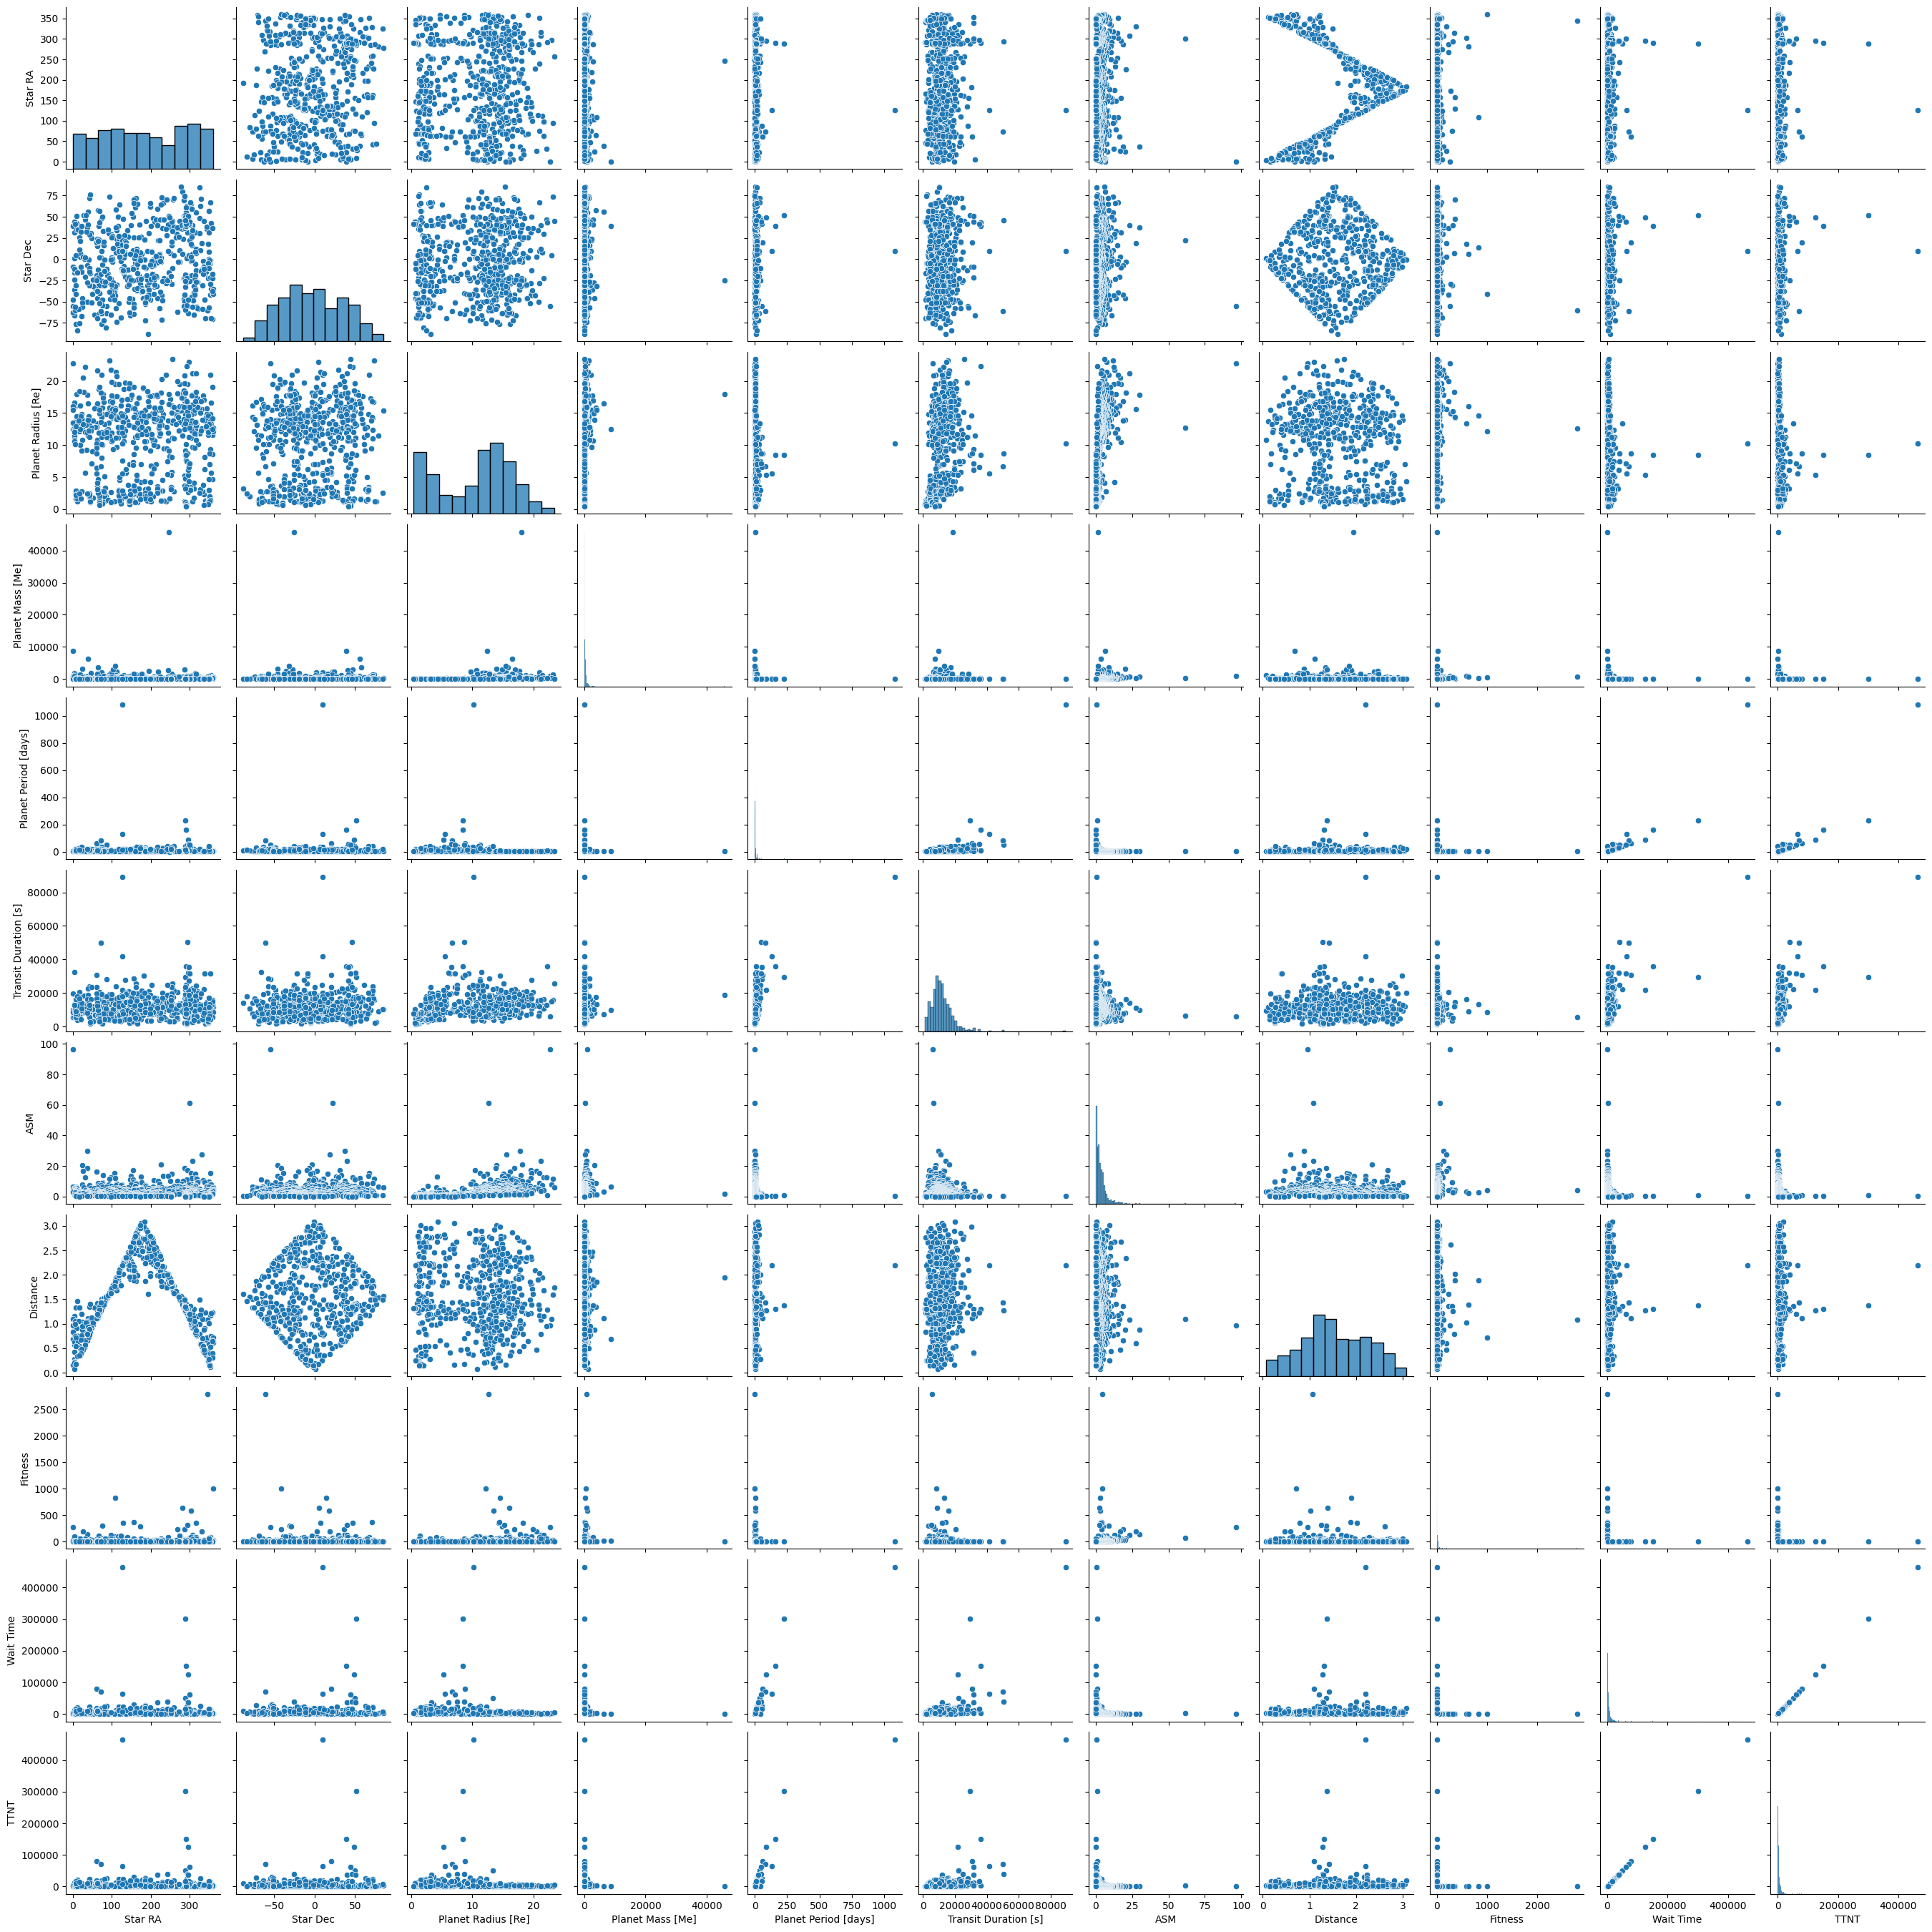

In [11]:
sns.pairplot(targets)